# AI

In [ ]:
# Prepaid your env first

pip install git+https://github.com/huggingface/transformers accelerate

In [ ]:
pip install minio load-dotenv pdfplumber qwen-vl-utils[decord]==0.0.8

In [38]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from PIL import Image
from minio import Minio
from dotenv import load_dotenv
from utils import get_txt_from_doc, pdf_to_images, clean_text

import pdfplumber
import torch
import re
import pickle
import io
import os

In [ ]:
load_dotenv()

YANDEX_CLOUD_ACCESS_KEY = os.getenv("YANDEX_CLOUD_ACCESS_KEY")
YANDEX_CLOUD_SECRET_KEY = os.getenv("YANDEX_CLOUD_SECRET_KEY")

In [62]:
# s3
BUCKET_NAME = 'rag-project'

# We need cuda
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

DEVICE

# 1. Prepad minio, pdf, model

In [ ]:
# Model
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# default processer
processor = AutoProcessor.from_pretrained(model_name)

In [22]:
client = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [ ]:
# # Upluad doc to S3
# object_key = '2412.19437v1.pdf'
# file_path = '/content/2412.19437v1.pdf'

# client.fput_object(
#     bucket_name=BUCKET_NAME,
#     object_name=object_key,
#     file_path=file_path,
#     content_type="application/pdf"
#     )

In [49]:
# Load pdf from s3
client.fget_object(
    bucket_name=BUCKET_NAME,
    object_name='2412.19437v1.pdf',
    file_path='/content/2412.19437v1.pdf'
    )

In [50]:
# Convert pdf to IMG
images = pdf_to_images(pdf_path='/content/2412.19437v1.pdf')

# 2. Example text from PDF

## 2.1 Prompt 1

**Промпт:**
Convert a document from an image to a text format, add detail information from the charts and table to text, dont write info not from document.

**Оценка:**
Текст переводится точно. Модель сохраняет структуру таблицы - современные LLM модели могут воспринимать таблицы в таком виде. Графики сомнительно интерпретируются моделью в таблицы, возможная проблема - низкое качество картинки, другое на Т4 в колабе не заводится

In [54]:
prompt_1 = "Convert a document from an image to a text format, add detail information from the charts and table to text, dont write info not from document."

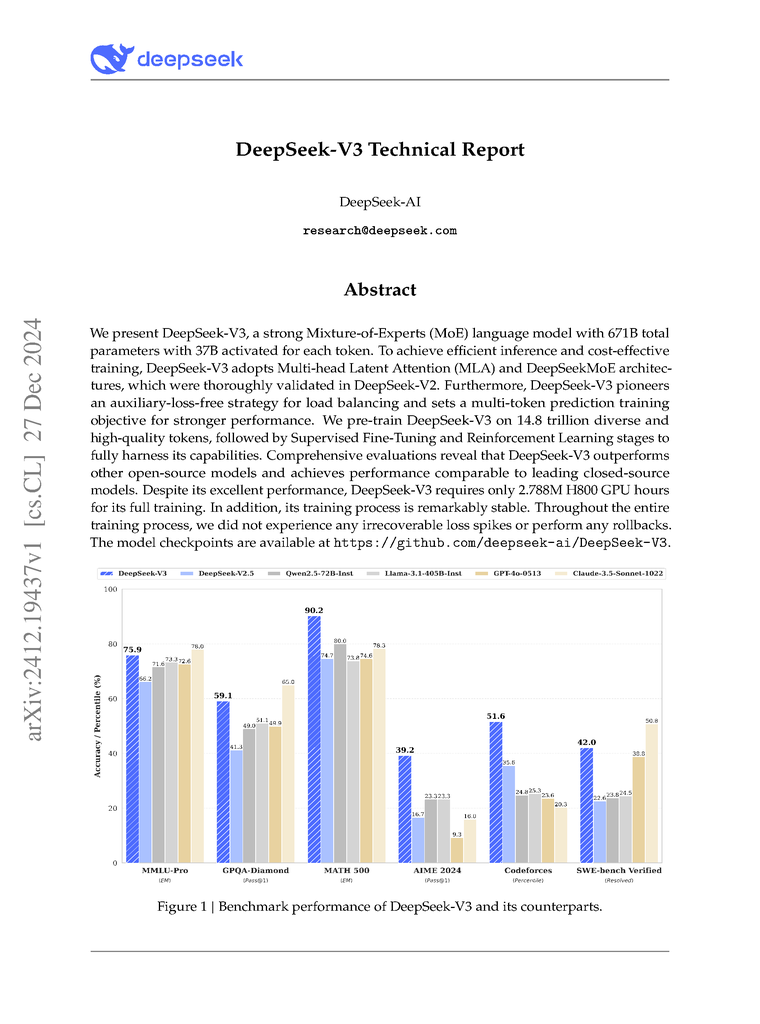

In [56]:
images[0]

In [57]:
output_text = get_txt_from_doc(images[0], prompt_1)
print(clean_text(output_text[0]))

DeepSeek-V3 Technical Report
DeepSeek-AI
research@deepseek.com
Abstract
We present DeepSeek-V3, a strong Mixture-of-Experts (MoE) language model with 671B total parameters with 37B activated for each token. To achieve efficient inference and cost-effective training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architectures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers an auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to fully harness its capabilities. Comprehensive evaluations reveal that DeepSeek-V3 outperforms other open-source models and achieves performance comparable to leading closed-source models. Despite its excellent performance, DeepSeek-V3 requires only 2.788M H800 GPU hours for its full traini

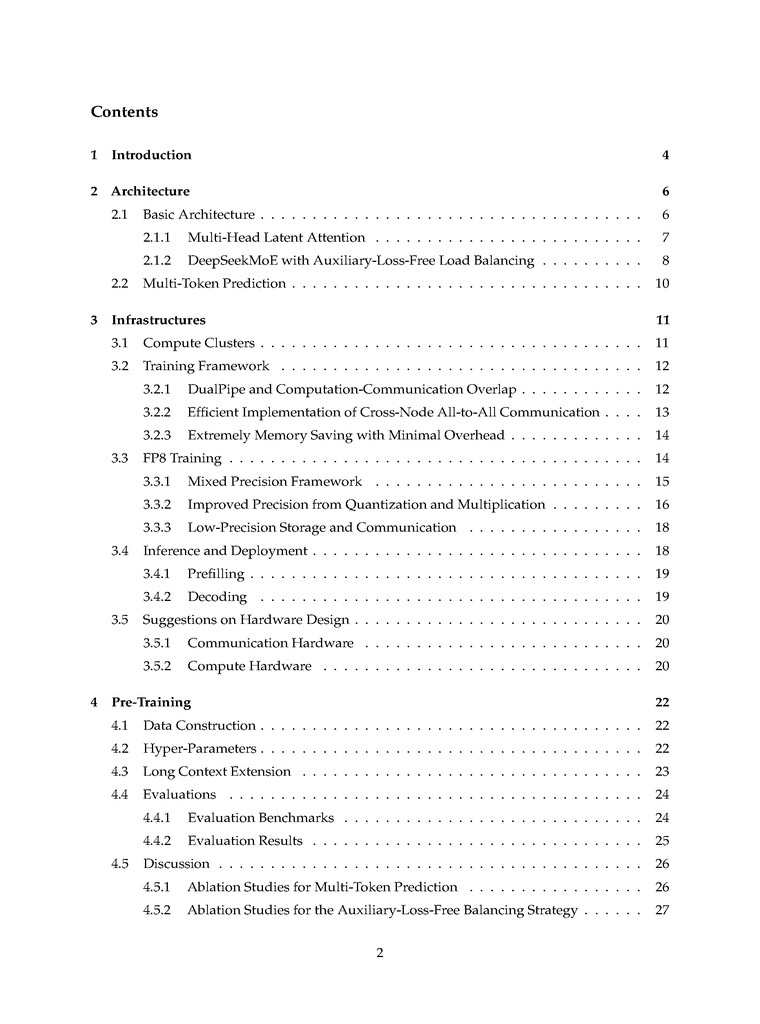

In [ ]:
images[1]

In [58]:
output_text = get_txt_from_doc(images[1], prompt_1)
print(clean_text(output_text[0]))

1 Introduction
2 Architecture
2.1 Basic Architecture
2.1.1 Multi-Head Latent Attention
2.1.2 DeepSeekMoE with Auxiliary-Loss-Free Load Balancing
2.2 Multi-Token Prediction
3 Infrastructures
3.1 Compute Clusters
3.2 Training Framework
3.2.1 DualPipe and Computation-Communication Overlap
3.2.2 Efficient Implementation of Cross-Node All-to-All Communication
3.2.3 Extremely Memory Saving with Minimal Overhead
3.3 FP8 Training
3.3.1 Mixed Precision Framework
3.3.2 Improved Precision from Quantization and Multiplication
3.3.3 Low-Precision Storage and Communication
3.4 Inference and Deployment
3.4.1 Prefiling
3.4.2 Decoding
3.5 Suggestions on Hardware Design
3.5.1 Communication Hardware
3.5.2 Compute Hardware
4 Pre-Training
4.1 Data Construction
4.2 Hyper-Parameters
4.3 Long Context Extension
4.4 Evaluations
4.4.1 Evaluation Benchmarks
4.4.2 Evaluation Results
4.5 Discussion
4.5.1 Ablation Studies for Multi-Token Prediction
4.5.2 Ablation Studies for the Auxiliary-Loss-Free Balancing Strateg

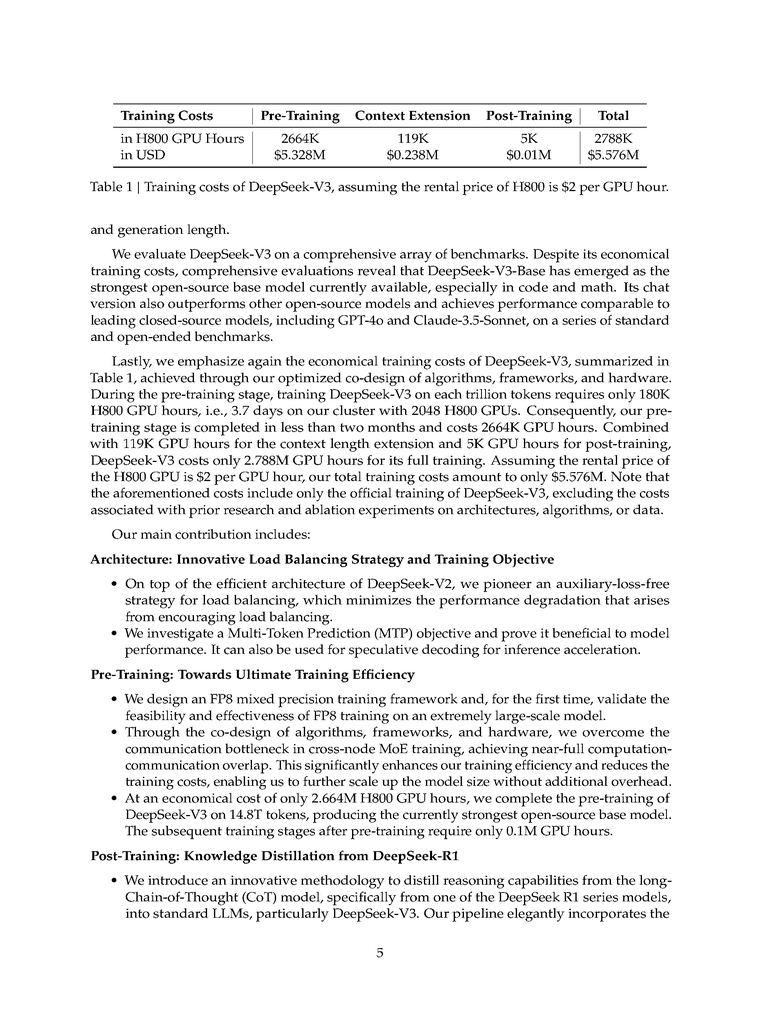

In [ ]:
images[4]

In [59]:
output_text = get_txt_from_doc(images[4], prompt_1)
print(clean_text(output_text[0]))

Table 1 | Training Costs of DeepSeek-V3
| Training Costs | Pre-Training | Context Extension | Post-Training | Total |
|----------------|---------------|-------------------|----------------|-------|
| in H800 GPU Hours | 2664K         | 119K              | 5K             | 2788K |
| in USD          | $5.328M       | $0.238M           | $0.01M         | $5.576M |
Table 1 | Training Costs of DeepSeek-V3, Assuming the Rental Price of H800 is $2 per GPU Hour.
We evaluate DeepSeek-V3 on a comprehensive array of benchmarks. Despite its economical training costs, comprehensive evaluations reveal that DeepSeek-V3-Base has emerged as the strongest open-source base model currently available, especially in code and math. Its chat version also outperforms other open-source models and achieves performance comparable to leading closed-source models, including GPT-4o and Claude-3.5-Sonnet, on a series of standard and open-ended benchmarks.
Lastly, we emphasize again the economical training costs of De

## 2.2 Prompt 2

**Промпт:**
Convert a document from an image to text format, you can use text and table information from image, dont use figure and charts.

**Оценка:**
Текст переводится точно. Модель не переводит графики в текст, что может позволить избежать галлюцинаций, но при этом мы теряем часть ифномрации.  

In [55]:
prompt_2 = "Convert a document from an image to text format, you can use text and table information from image, dont use figure and charts"

In [96]:
# Image 0
output_text = get_txt_from_doc(images[0], prompt)
print(clean_text(output_text[0]))

DeepSeek-V3 Technical Report
DeepSeek-AI
research@deepseek.com
Abstract
We present DeepSeek-V3, a strong Mixture-of-Experts (MoE) language model with 671B total parameters with 37B activated for each token. To achieve efficient inference and cost-effective training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architectures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers an auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to fully harness its capabilities. Comprehensive evaluations reveal that DeepSeek-V3 outperforms other open-source models and achieves performance comparable to leading closed-source models. Despite its excellent performance, DeepSeek-V3 requires only 2.788M H800 GPU hours for its full traini

In [99]:
# Image 1
output_text = get_txt_from_doc(images[1], prompt_2)
print(clean_text(output_text[0]))

1 Introduction
2 Architecture
2.1 Basic Architecture
2.1.1 Multi-Head Latent Attention
2.1.2 DeepSeekMoE with Auxiliary-Loss-Free Load Balancing
2.2 Multi-Token Prediction
3 Infrastructures
3.1 Compute Clusters
3.2 Training Framework
3.2.1 DualPipe and Computation-Communication Overlap
3.2.2 Efficient Implementation of Cross-Node All-to-All Communication
3.2.3 Extremely Memory Saving with Minimal Overhead
3.3 FP8 Training
3.3.1 Mixed Precision Framework
3.3.2 Improved Precision from Quantization and Multiplication
3.3.3 Low-Precision Storage and Communication
3.4 Inference and Deployment
3.4.1 Prefiling
3.4.2 Decoding
3.5 Suggestions on Hardware Design
3.5.1 Communication Hardware
3.5.2 Compute Hardware
4 Pre-Training
4.1 Data Construction
4.2 Hyper-Parameters
4.3 Long Context Extension
4.4 Evaluations
4.4.1 Evaluation Benchmarks
4.4.2 Evaluation Results
4.5 Discussion
4.5.1 Ablation Studies for Multi-Token Prediction
4.5.2 Ablation Studies for the Auxiliary-Loss-Free Balancing Strateg

In [98]:
# Image 4
output_text = get_txt_from_doc(images[4], prompt_2)
print(clean_text(output_text[0]))

| Training Costs | Pre-Training | Context Extension | Post-Training | Total |
|----------------|--------------|------------------|----------------|-------|
| in H800 GPU Hours | 2664K        | 119K             | 5K             | 2788K |
| in USD          | $5.328M      | $0.238M          | $0.01M         | $5.576M |
Table 1 | Training costs of DeepSeek-V3, assuming the rental price of H800 is $2 per GPU hour.
We evaluate DeepSeek-V3 on a comprehensive array of benchmarks. Despite its economical training costs, comprehensive evaluations reveal that DeepSeek-V3-Base has emerged as the strongest open-source base model currently available, especially in code and math. Its chat version also outperforms other open-source models and achieves performance comparable to leading closed-source models, including GPT-4o and Claude-3.5-Sonnet, on a series of standard and open-ended benchmarks.
Lastly, we emphasize again the economical training costs of DeepSeek-V3, summarized in Table 1, achieved thr

# 3. Get text from PDF

Prompt 1

In [ ]:
pdf_2412_19437v1_prompt1 = dict()

for pg_num, page in enumerate(images):
  output_text = get_txt_from_doc(
      image=page,
      prompt=prompt_1,
      model=model,
      processor=processor,
      device=DEVICE
      )
  text = clean_text(output_text[0])

  # page_num : parse_text
  pdf_2412_19437v1_prompt1[pg_num] = text

In [120]:
# Сериализация словаря в Pickle
pickle_data = pickle.dumps(pdf_2412_19437v1_prompt1)

client.put_object(
    bucket_name=BUCKET_NAME,
    object_key,
    data=io.BytesIO(pickle_data),
    length=len(pickle_data),
    content_type="application/octet-stream"  # Бинарный формат
)

In [ ]:
# load from s3
client.fget_object(
    bucket_name=BUCKET_NAME, 
    object_name='pdf_2412_19437v1_prompt1.pkl',
    file_path='/content/pdf_2412_19437v1_prompt1.pkl'
    )

with open("/content/pdf_2412_19437v1_prompt1.pkl", "rb") as file:
    deserialized_data = pickle.load(file)

In [ ]:
assert deserialized_data[0] == pdf_2412_19437v1_prompt1[0], 'not equal doc after pickle'

Prompt 2

In [32]:
pdf_2412_19437v1_prompt2 = dict()

for pg_num, page in enumerate(images):
  output_text = get_txt_from_doc(
      image=page, 
      prompt=prompt_2,
      model=model,
      processor=processor,
      device=DEVICE
      )
  text = clean_text(output_text[0])

  # page_num : parse_text
  pdf_2412_19437v1_prompt2[pg_num] = text

In [ ]:
# Upload to s3
pickle_data = pickle.dumps(pdf_2412_19437v1_prompt2)

client.put_object(
    bucket_name=BUCKET_NAME,
    object_name='pdf_2412_19437v1_prompt2.pkl',
    data=io.BytesIO(pickle_data),
    length=len(pickle_data),
    content_type="application/octet-stream"
)

# 4. Alternative: Pymupdf

Хороший перенос текста из документа, но не работает с таблицами и графиками

In [ ]:
pip install pymupdf

In [138]:
import fitz

In [139]:
# Doc
document = fitz.open("/content/2412.19437v1.pdf")

In [140]:
# Get text from doc with fitz
ttl_doc_txt = []

for page_num in range(document.page_count):
    page = document.load_page(page_num)
    globals()[f"page{page_num}"] = page.get_text()
    ttl_doc_txt.append(globals()[f"page{page_num}"])

In [142]:
print(clean_text(ttl_doc_txt[0]))

DeepSeek-V3 Technical Report
DeepSeek-AI
research@deepseek.com
Abstract
We present DeepSeek-V3, a strong Mixture-of-Experts (MoE) language model with 671B total
parameters with 37B activated for each token. To achieve efficient inference and cost-effective
training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-
tures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers
an auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to
fully harness its capabilities. Comprehensive evaluations reveal that DeepSeek-V3 outperforms
other open-source models and achieves performance comparable to leading closed-source
models. Despite its excellent performance, DeepSeek-V3 requires only 2.788M H800 GPU hours
for its full trai

In [143]:
print(ttl_doc_txt[4])

Training Costs
Pre-Training
Context Extension
Post-Training
Total
in H800 GPU Hours
2664K
119K
5K
2788K
in USD
$5.328M
$0.238M
$0.01M
$5.576M
Table 1 | Training costs of DeepSeek-V3, assuming the rental price of H800 is $2 per GPU hour.
and generation length.
We evaluate DeepSeek-V3 on a comprehensive array of benchmarks. Despite its economical
training costs, comprehensive evaluations reveal that DeepSeek-V3-Base has emerged as the
strongest open-source base model currently available, especially in code and math. Its chat
version also outperforms other open-source models and achieves performance comparable to
leading closed-source models, including GPT-4o and Claude-3.5-Sonnet, on a series of standard
and open-ended benchmarks.
Lastly, we emphasize again the economical training costs of DeepSeek-V3, summarized in
Table 1, achieved through our optimized co-design of algorithms, frameworks, and hardware.
During the pre-training stage, training DeepSeek-V3 on each trillion tokens require

# 5. Alternative - pdfplumber

pdfplumber - не походит, при конвертиции объединяет слова, конвертирует с ошибками, не подходит для интерпретации таблиц и графиков

In [146]:
import pdfplumber

In [147]:
# Get dext from doc with pdfplumber
pdfplumber_book = {}

with pdfplumber.open("/content/2412.19437v1.pdf") as pdf:

    for page_number, page in enumerate(pdf.pages, start=1):
        text = page.extract_text()
        if text:
            pdfplumber_book[page_number] = text
        else:
            print(f"--- Нет текста на странице {page_number} ---")

In [150]:
print(clean_text(pdfplumber_book[1]))

DeepSeek-V3 Technical Report
DeepSeek-AI
research@deepseek.com
Abstract
WepresentDeepSeek-V3,astrongMixture-of-Experts(MoE)languagemodelwith671Btotal
parameterswith37Bactivatedforeachtoken. Toachieveefficientinferenceandcost-effective
training,DeepSeek-V3adoptsMulti-headLatentAttention(MLA)andDeepSeekMoEarchitec-
tures,whichwerethoroughlyvalidatedinDeepSeek-V2. Furthermore,DeepSeek-V3pioneers
an auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high-qualitytokens,followedbySupervisedFine-TuningandReinforcementLearningstagesto
fullyharnessitscapabilities. ComprehensiveevaluationsrevealthatDeepSeek-V3outperforms
other open-source models and achieves performance comparable to leading closed-source
models. Despiteitsexcellentperformance,DeepSeek-V3requiresonly2.788MH800GPUhours
foritsfulltraining. Inaddition,itstrainingprocessisremarkablystable. Throughouttheen

In [151]:
print(clean_text(pdfplumber_book[5]))

TrainingCosts Pre-Training ContextExtension Post-Training Total
inH800GPUHours 2664K 119K 5K 2788K
inUSD $5.328M $0.238M $0.01M $5.576M
Table1 | TrainingcostsofDeepSeek-V3,assumingtherentalpriceofH800is$2perGPUhour.
andgenerationlength.
WeevaluateDeepSeek-V3onacomprehensivearrayofbenchmarks. Despiteitseconomical
trainingcosts,comprehensiveevaluationsrevealthatDeepSeek-V3-Basehasemergedasthe
strongest open-source base model currently available, especially in code and math. Its chat
versionalsooutperformsotheropen-sourcemodelsandachievesperformancecomparableto
leadingclosed-sourcemodels,includingGPT-4oandClaude-3.5-Sonnet,onaseriesofstandard
andopen-endedbenchmarks.
Lastly,weemphasizeagaintheeconomicaltrainingcostsofDeepSeek-V3,summarizedin
Table1,achievedthroughouroptimizedco-designofalgorithms,frameworks,andhardware.
Duringthepre-trainingstage,trainingDeepSeek-V3oneachtrilliontokensrequiresonly180K
H800 GPU hours, i.e., 3.7 days on our cluster with 2048 H800 GPUs. Consequently, our pre